# Прогнозирование дохода.

## Описание данных.

Нам был предоставлен интересный датасет, который содержит в себе данные о людях, а именно:<br> <br>
**1) age (возраст);** <br>
**2) workclass (сфера занятости);** <br>
**3) fnlwgt (весовой коэффициент);** <br>
**4) education (образование);** <br>
**5) education.num (числовое представление уровня образования);** <br>
**6) marital.status (семейное положение);** <br>
**7) occupation (профессия);** <br>
**8) relationship (отношения в семье);** <br>
**9) race (раса);** <br>
**10) sex (пол);** <br>
**11) capital.gain (прирост капитала);** <br>
**12) capital.loss (убыток капитала);** <br>
**13) hours.per.week (количество рабочих часов в неделю);** <br>
**14) native.country (родная страна);** <br>
**15) income (доход).** <br> <br>
Имею данную информацию, нам необходимо подобрать лучшую модель для решения задачи классификации, а именно для выявления дохода человека ('income').

## Загрузка данных.

In [1]:
! pip install phik


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 


RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
df = pd.read_csv('/Users/nolvi/Downloads/adult.csv')

In [4]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Промежуточный вывод:**<br>Данные прекрасны!<br>По первому взгляду, стоит обратить внимание на значения '?' в некоторых столбцах.

## Предобработка данных.

Исправим названия некоторых столбцов, чтобы с ними было удобнее работать.

In [6]:
df = df.rename(columns={'capital.gain': 'capital_gain'})
df = df.rename(columns={'education.num': 'education_num'})
df = df.rename(columns={'marital.status': 'marital_status'})
df = df.rename(columns={'capital.loss': 'capital_loss'})
df = df.rename(columns={'hours.per.week': 'hours_per_week'})
df = df.rename(columns={'native.country': 'native_country'})

Избавимся от не до конца незаполненных строк.

In [7]:
def non_q(df, columns):
    for column in columns:
        if (df[column] == '?').any():
            df = df[df[column] != '?']
            print(f'В столбце {column} удаления строк, содержащих "?" прошло успешно!')
        else:
            print(f'В столбце {column} "?" не обнаружен!')
    df = df.reset_index(drop = True)
    return df

In [8]:
df = non_q(df, df.columns)

В столбце age "?" не обнаружен!
В столбце workclass удаления строк, содержащих "?" прошло успешно!
В столбце fnlwgt "?" не обнаружен!
В столбце education "?" не обнаружен!
В столбце education_num "?" не обнаружен!
В столбце marital_status "?" не обнаружен!
В столбце occupation удаления строк, содержащих "?" прошло успешно!
В столбце relationship "?" не обнаружен!
В столбце race "?" не обнаружен!
В столбце sex "?" не обнаружен!
В столбце capital_gain "?" не обнаружен!
В столбце capital_loss "?" не обнаружен!
В столбце hours_per_week "?" не обнаружен!
В столбце native_country удаления строк, содержащих "?" прошло успешно!
В столбце income "?" не обнаружен!


In [9]:
df.head(20)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
5,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
6,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
7,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
8,38,Self-emp-not-inc,164526,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,>50K
9,52,Private,129177,Bachelors,13,Widowed,Other-service,Not-in-family,White,Female,0,2824,20,United-States,>50K


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education_num   30162 non-null  int64 
 5   marital_status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital_gain    30162 non-null  int64 
 11  capital_loss    30162 non-null  int64 
 12  hours_per_week  30162 non-null  int64 
 13  native_country  30162 non-null  object
 14  income          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.5+ MB


**Промежуточный вывод:**<br> Предобработка выполнена успешно.

## Корреляционный анализ.

interval columns not set, guessing: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


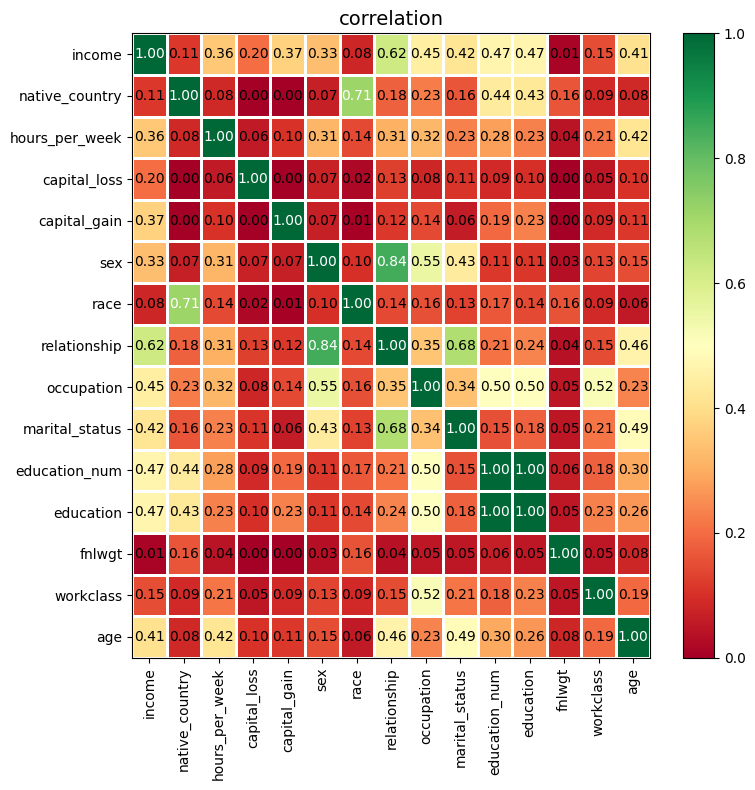

In [11]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    figsize=(8, 8)
)

plt.show()
None

**Промежуточный вывод:**<br>По матрице корреляции видно, что мультиколлениарности между признаками и нашей целевой переменной не наблюдается.<br>Близкая к сильной зависимость присутствует между нашим ЦП и 'отношением в семье'.<br>Немного меньше имеет влияение 'професиия', 'семейное положение', 'образование' и 'возраст'.<br>Слабая зависимость между ЦП и 'рассой', 'сферой деятельности', 'страной'.<br>И почти отсутствует зависимость между ЦП и 'весовым коэффициентом'.

## Подготовка данных.

In [12]:
X = df.drop('income', axis = 1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

cat = ['workclass','education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
num = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [13]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),
        ('cat', cat_transformer, cat)
    ],
    remainder='passthrough'
)

In [14]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('models', RandomForestClassifier())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('models', RandomForestClassifier())])

**Промежуточный вывод:**<br>Обработка данных пройдена, теперь обучим модели и выберем лучшую.

## Поиск лучшей модели.

In [15]:
param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_estimators': [50, 100, 200, 300],
        'models__max_depth': range(5, 15),
        'models__max_features': [2, 3, 'auto', None]
    },
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_estimators': [50, 100, 200, 300],
        'models__max_depth': range(3, 8),
        'models__learning_rate': [0.01, 0.1, 0.2]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__solver': ['lbfgs', 'liblinear', 'saga'],
        'models__max_iter': [100, 200, 300]
    }
]

In [16]:
random_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Ver

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'fnlwgt',
                                                                                'education_num',
                                                                                'capital_gain',
                                                                                'capital_loss',
                                                                                'hours_per_week']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHot...
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [0.01, 0.1, 1, 10, 100],
                                         'models__max_iter': [100, 200, 300],
                                         'models__penalty': ['l1', 'l2',
                                                             'elasticnet',
                                                             'none'],
                                         'models__solver': ['lbfgs',
                                                            'liblinear',
                                                            'saga'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [17]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Лучший ROC AUC на обучении: ', random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'edu

**Промежуточный вывод:**<br>Лучшей оказалась RandomForestClassifier. Значение метрики удивляет.

## Тестирование лучшей модели.

In [18]:
y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC на тестовой выборке: ', roc_auc)

ROC AUC на тестовой выборке:  0.9104706228399148


**Промежуточный вывод:**<br>Значения на тестовой выборке показывают также отличный результат. Модель успешно работает.

## Общий вывод.

Целью проекта было создать модель для предсказания уровня дохода людей.<br>Сначала мы обработали пропущенные значения, переименованы столбцы, удалили строки, где присутствует знак "?".<br>Далее мы посмотрели на матрицу корреляции, и выяснили, что мультиколлинеарность отсутствует, однакко имеется сильная зависимость дохода с признаками "отношение в семье", "профессия", "семейное положение", "образование" и "возраст".<br>После предобработки данных мы приступили к обучению модели. Выяснилось, что лучшая модель: RandomForestClassifier с параметрами max_depth=11, max_features=None, n_estimators=200, random_state=42 и результатом метрики ROC-AUC: 0.9148.<br> Значит проект успешно выполнен, ведь наша модель прекрасно предсказывает уровень дохода на основе данных.